In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from pylab import rcParams
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
import MetaTrader5 as mt5
from datetime import timedelta
import datetime

#### Reino Unido - Índice PMI del sector servicios

El Indice de los Gerentes de Compra del Chartered Institute of Purchasing and Supply (CIPS), mide el nivel de actividad de los gerentes de compra en el sector servicios.
Cualquier lectura por encima de 50 indica expansión, mientras que una lectura por debajo de 50 indica contracción. < BR /> Da una indicación acerca de la salud de la industria de servicios en el Reino Unido. Los comerciantes ven de cerca estas encuestas ya que, como jefes de compras, por lo general tienen un acceso fácil a datos sobre el rendimiento de su empresa, lo que puede ser un indicador de los resultados económicos globales.
Un mayor lectura de la esperada debe ser tomada como positiva / alcista para el GBP, mientras que una lectura inferior a lo esperado debería ser tomada como negativa y bajista para el GBP.

In [346]:
pmi = pd.read_excel("Indice PMI sector servicios GBP.xlsx")

def Replace(str1):
    maketrans = str1.maketrans
    final = str1.translate(maketrans(',.', '.,', ' '))
    return final.replace(',', ", ")

actual = [float(Replace(pmi["Actual"][i])) for i in range(0, len(pmi["Actual"]))]
prevision = [float(Replace(pmi["Prevision"][i])) for i in range(0, len(pmi["Prevision"]))]
anterior = [float(Replace(pmi["Anterior"][i])) for i in range(0, len(pmi["Anterior"]))]
temp = [pmi["Fecha de publicacion"][i].replace(".","-") for i in range(0, len(pmi["Fecha de publicacion"]))]
temp = ["{2}-{1}-{0}".format(*temp[i].split('-')) for i in range(0,len(temp))]
fecha = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours = []
for i in pmi["Hora"]:
    if isinstance(i,datetime.time):
        hours.append(i)
    else:
        hours.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())
        
pmi["Actual"] = actual
pmi["Prevision"] = prevision
pmi["Anterior"] = anterior
pmi["Fecha de publicacion"] = fecha
pmi["Hora"] = hours
pmi.set_index("Fecha de publicacion", inplace=True);

pmi["Hora"] = [datetime.datetime.combine(pmi.index[i], pmi["Hora"][i]) for i in range(0, len(pmi.index))]
pmi.rename(columns = {"Hora": "Fecha y hora"}, inplace=True)
pmi.set_index("Fecha y hora", inplace=True)
pmi.drop(pmi.index[0], inplace=True)

In [276]:
pmi.head()

,Actual,Prevision,Anterior
Fecha y hora,,,
2021-04-07 10:30:00,56.3,56.8,49.5
2021-03-24 11:30:00,56.8,51.0,49.5
2021-03-03 11:30:00,49.5,49.7,39.5
2021-02-19 11:30:00,49.7,41.0,39.5
2021-02-03 11:30:00,39.5,38.8,38.8


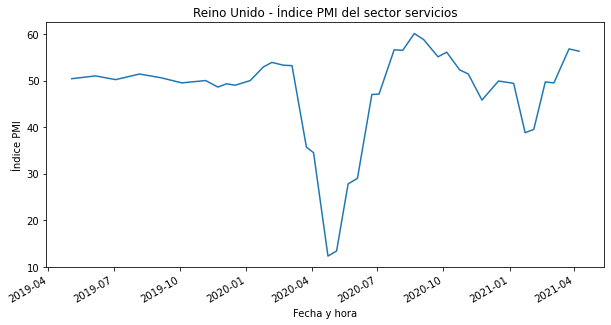

In [277]:
pmi["Actual"].plot(figsize=(10,5));
plt.ylabel("Índice PMI");
plt.title("Reino Unido - Índice PMI del sector servicios");

#### 1. Componente de Autocorrelación y Autocorrelación Parcial

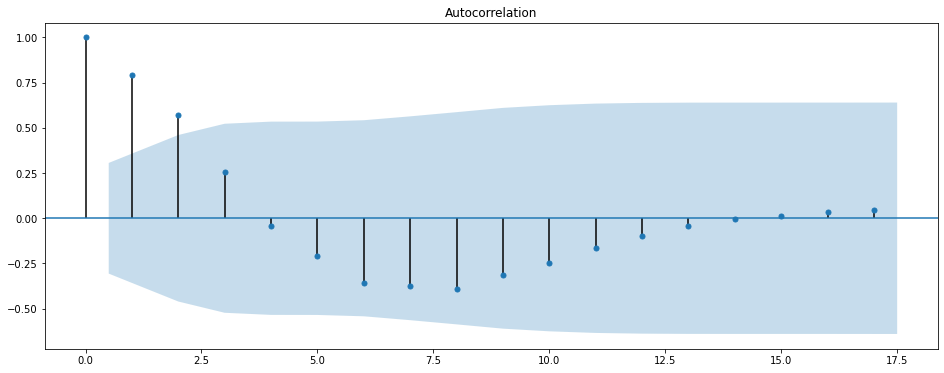

In [278]:
plot_acf(pmi["Actual"]);

Componente de autocorrelación igual a 2

C:\Users\patri\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


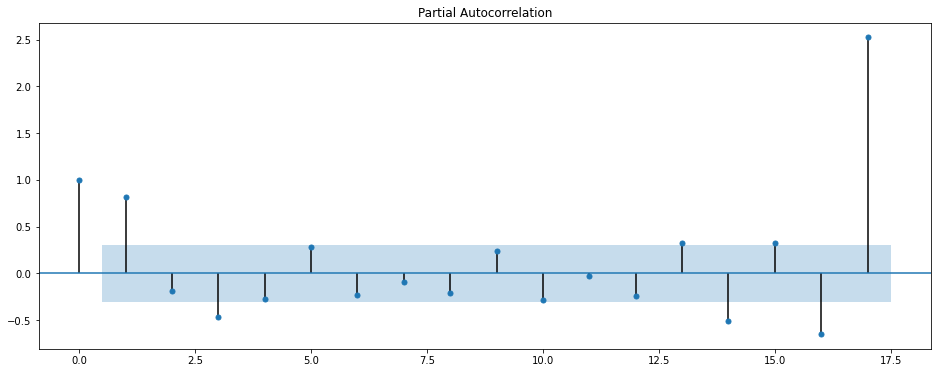

In [279]:
plot_pacf(pmi["Actual"]);

Componente de autocorrelación parcial igual a 1

#### 2. Prueba de Heterocedasticidad

In [280]:
def reglin(x,y):
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    B0 = model.params[0]
    B1 = model.params[1]
    x = x[:, 1]
    
    x2 = np.linspace(x.min(), x.max(),100)
    y_hat = x2 * B1 + B0
    plt.scatter(x, y, alpha=1)
    plt.plot(x2, y_hat, "r", alpha=1)
    plt.xlabel("Tiempo")
    plt.ylabel("PMI")
    return model, B0, B1

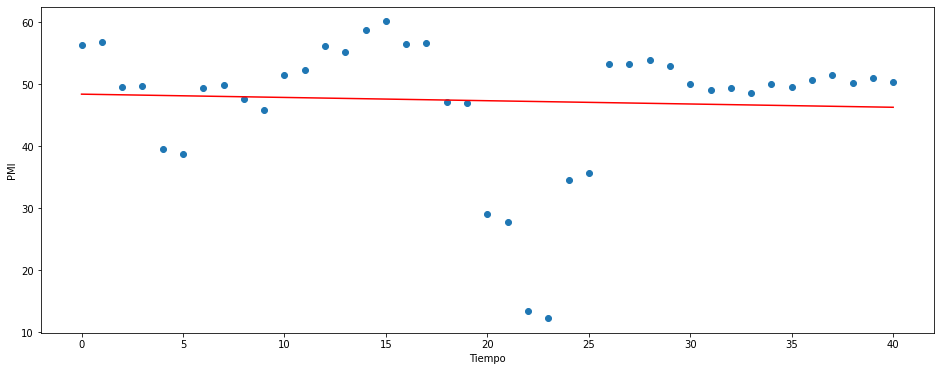

In [281]:
pmi.reset_index(inplace=True)
reglin(pmi.index, pmi["Actual"])
pmi.set_index("Fecha y hora", inplace=True)
#plt.title("Regresión lineal")

#### 3. Prueba de Normalidad

In [282]:
stat, p = shapiro(pmi["Actual"])
alpha = 0.05
if p > alpha:
    print('Es normal')
else:
    print('No es normal')

No es normal


#### 4. Estacionalidad

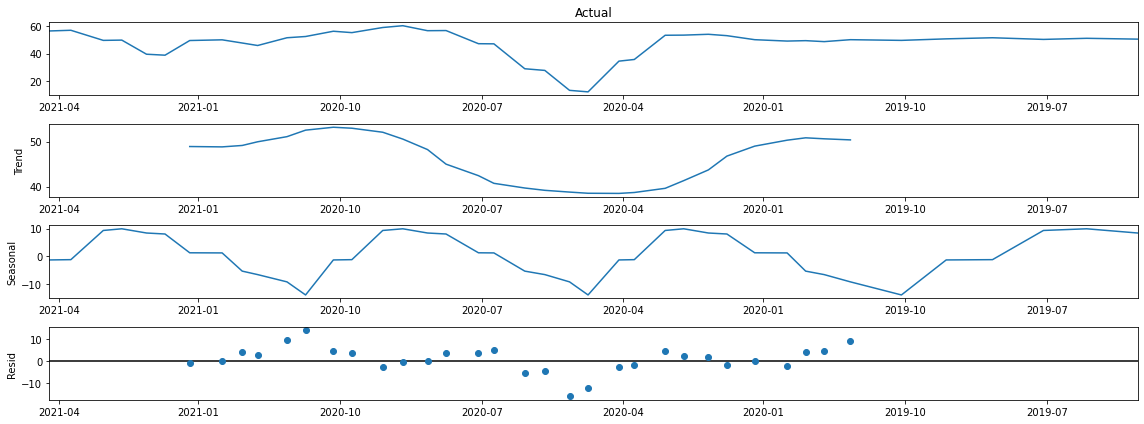

In [283]:
rcParams['figure.figsize'] = 16, 6
decomposition = sm.tsa.seasonal_decompose(pmi["Actual"], model='additive', period=12)
fig = decomposition.plot()
plt.show()

#### 5. Estacionariedad

In [284]:
def estacionariedad(serie_de_tiempo):
    ## Test de DICKEY-FULLER
    adf_test = adfuller(serie_de_tiempo)
    if adf_test[1] > 0.05:
        print("No es estacionaria")
    else:
        print("Es estacionaria")

In [285]:
estacionariedad(pmi["Actual"])

No es estacionaria


#### 6. Detección de Atípicos

Text(0.5, 1.0, 'Detección de Atípicos')

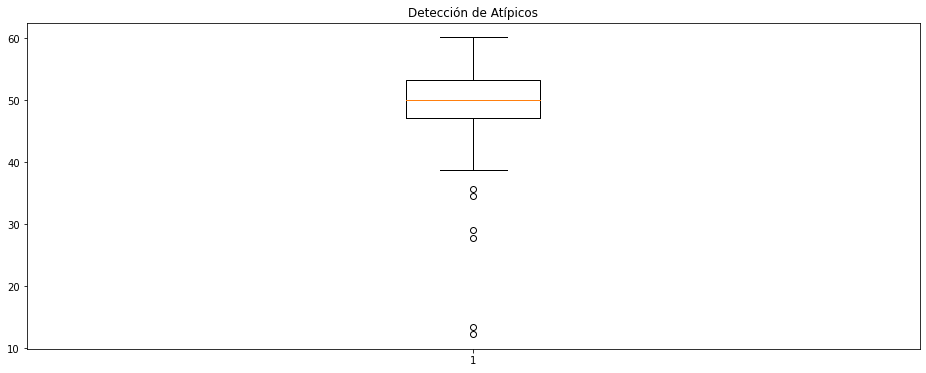

In [286]:
plt.boxplot(pmi["Actual"]);
plt.title("Detección de Atípicos")

#### Precios Históricos

In [164]:
gbp_usd_2019 = pd.read_csv("DAT_MT_GBPUSD_M1_2019.csv")
gbp_usd_2020 = pd.read_csv("DAT_MT_GBPUSD_M1_2020.csv")
gbp_usd_2021_e = pd.read_excel("DAT_XLSX_GBPUSD_M1_202101.xlsx")
gbp_usd_2021_f = pd.read_excel("DAT_XLSX_GBPUSD_M1_202102.xlsx")
gbp_usd_2021_m = pd.read_excel("DAT_XLSX_GBPUSD_M1_202103.xlsx")
gbp_usd_2021_a = pd.read_excel("DAT_XLSX_GBPUSD_M1_202104.xlsx")

temp = [gbp_usd_2019["Fecha"][i].replace(".","-") for i in range(0, len(gbp_usd_2019["Fecha"]))]
fecha_2019 = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours_2019 = []
for i in gbp_usd_2019["Hora"]:
    if isinstance(i,datetime.time):
        hours_2019.append(i)
    else:
        hours_2019.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())
        
gbp_usd_2019["Fecha"] = fecha_2019
gbp_usd_2019["Hora"] = hours_2019

temp = [gbp_usd_2020["Fecha"][i].replace(".","-") for i in range(0, len(gbp_usd_2020["Fecha"]))]
fecha_2020 = [datetime.datetime.strptime(temp[i], "%Y-%m-%d") for i in range(0, len(temp))]

hours_2020 = []
for i in gbp_usd_2020["Hora"]:
    if isinstance(i,datetime.time):
        hours_2020.append(i)
    else:
        hours_2020.append(datetime.datetime.strptime(i.strip(), '%H:%M').time())
        
gbp_usd_2020["Fecha"] = fecha_2020
gbp_usd_2020["Hora"] = hours_2020

fechayhora_2019 = [datetime.datetime.combine(gbp_usd_2019["Fecha"][i], gbp_usd_2019["Hora"][i]) for i in range(0, len(gbp_usd_2019["Fecha"]))]
gbp_usd_2019["Fecha"] = fechayhora_2019
gbp_usd_2019.drop(["Hora"], axis=1, inplace=True)
gbp_usd_2019.rename(columns={"Fecha": "Fecha y hora"}, inplace=True)

fechayhora_2020 = [datetime.datetime.combine(gbp_usd_2020["Fecha"][i], gbp_usd_2020["Hora"][i]) for i in range(0, len(gbp_usd_2020["Fecha"]))]
gbp_usd_2020["Fecha"] = fechayhora_2020
gbp_usd_2020.drop(["Hora"], axis=1, inplace=True)
gbp_usd_2020.rename(columns={"Fecha": "Fecha y hora"}, inplace=True)

frames = [gbp_usd_2019, gbp_usd_2020, gbp_usd_2021_e, gbp_usd_2021_f, gbp_usd_2021_m, gbp_usd_2021_a]
precios_gbp_usd = pd.concat(frames)
precios_gbp_usd.set_index("Fecha y hora", inplace=True)

In [165]:
precios_gbp_usd.head()

,Open,High,Low,Close
Fecha y hora,,,,
2019-01-01 17:06:00,1.27459,1.27459,1.27250,1.27250
2019-01-01 17:11:00,1.27227,1.27227,1.27227,1.27227
2019-01-01 17:12:00,1.27294,1.27294,1.27294,1.27294
2019-01-01 17:13:00,1.27294,1.27295,1.27294,1.27295
2019-01-01 17:14:00,1.27295,1.27295,1.27277,1.27277


In [347]:
def f_escenario(data):
    """
    Paramemters
    -----------
    data: nuestro data ya limpio y solo seleccionando los primeros 24 datos
    ---------
    returns
    -------
    data: regresa el mismo data con la columna de de escenarios
    """

    data['Escenario'] = None

    for i in range(len(data)):
        if data.iloc[i, 0] >= data.iloc[i, 1] and \
                data.iloc[i, 1] >= data.iloc[i, 2]:
            data.iloc[i, 3] = 'A'

        elif data.iloc[i, 0] >= data.iloc[i, 1] and \
                data.iloc[i, 1] < data.iloc[i,2]:
            data.iloc[i, 3] = 'B'

        elif data.iloc[i, 0] < data.iloc[i, 1] and \
                data.iloc[i, 1] >= data.iloc[i, 2]:
            data.iloc[i, 3] = 'C'

        elif data.iloc[i, 0] < data.iloc[i, 1] and \
                data.iloc[i, 1] < data.iloc[i, 2]:
            data.iloc[i, 3] = 'D'

    return data

In [348]:
f_escenario(pmi);

In [470]:
def f_metricas(indicador):    
    date_time = []
    for i in indicador.index:
        date_time.append(datetime.datetime.fromtimestamp(datetime.datetime.timestamp(i)))

    tiempos = []
    for i in date_time:
        for j in range(1,62):
            tiempos.append(i - datetime.timedelta(minutes=31) + datetime.timedelta(minutes=j))

    df_filtrado_por_indicador = pd.concat([precios_gbp_usd[precios_gbp_usd.index == str(i)] for i in tiempos])

    direccion = []
    iterador_t_0 = list(range(-31, len(df_filtrado_por_indicador), 61))
    iterador_t_0.pop(0);
    iterador_t_30 = list(range(-1, len(df_filtrado_por_indicador), 61))
    iterador_t_30.pop(0);

    for i in iterador_t_0:  
        t_0 = df_filtrado_por_indicador.iloc[i, 0]
        for j in iterador_t_30:
            t_30 = df_filtrado_por_indicador.iloc[j, 3]
        direccion.append(t_30 - t_0)

    indicador["Direccion"] = direccion
    
    #(Pips Alcistas) High(t_0 : t_30) – Open(t_0)
    
    high_hasta_t_30 = []
    for i in iterador_t_0: 
        high_hasta_t_30.append(max(df_filtrado_por_indicador.iloc[i: i + 31,1]))

    pips_alcistas = []
    for i in iterador_t_0:
        t_0 = df_filtrado_por_indicador.iloc[i, 0]
        for j in high_hasta_t_30:
            t_max = j
        pips_alcistas.append(t_max - t_0)
        
    indicador["Pips Alcistas"] = pips_alcistas
    
    #(Pips Bajistas) Open(t_0) – Low(t_0 : t_30) 
    
    low_hasta_t_30 = []
    for i in iterador_t_0: 
        low_hasta_t_30.append(min(df_filtrado_por_indicador.iloc[i: i + 31,1]))

    pips_bajistas = []
    for i in iterador_t_0:
        t_0 = df_filtrado_por_indicador.iloc[i, 0]
        for j in low_hasta_t_30:
            t_min = j
        pips_bajistas.append(t_0 - t_min)
        
    indicador["Pips Bajistas"] = pips_bajistas
     
    return indicador

In [471]:
f_metricas(pmi)

,Actual,Prevision,Anterior,Escenario,Direccion,Pips Alcistas,Pips Bajistas
Fecha y hora,,,,,,,
2021-04-07 10:30:00,56.3,56.8,49.5,C,-0.06541,-0.06502,0.06969
2021-03-24 11:30:00,56.8,51.0,49.5,A,-0.06108,-0.06069,0.06536
2021-03-03 11:30:00,49.5,49.7,39.5,C,-0.08700,-0.08661,0.09128
2021-02-19 11:30:00,49.7,41.0,39.5,A,-0.09012,-0.08973,0.09440
2021-02-03 11:30:00,39.5,38.8,38.8,A,-0.05329,-0.05290,0.05757
2021-01-22 11:30:00,38.8,49.9,49.4,C,-0.05457,-0.05418,0.05885
2021-01-06 11:30:00,49.4,49.9,47.6,C,-0.04610,-0.04571,0.05038
2020-12-16 11:30:00,49.9,50.5,47.6,C,-0.03714,-0.03675,0.04142
2020-12-03 11:30:00,47.6,45.8,51.4,B,-0.03730,-0.03691,0.04158


In [465]:
date_time = []
for i in pmi.index:
    date_time.append(datetime.datetime.fromtimestamp(datetime.datetime.timestamp(i)))

tiempos = []
for i in date_time:
    for j in range(1,62):
        tiempos.append(i - datetime.timedelta(minutes=31) + datetime.timedelta(minutes=j))

df_filtrado_por_indicador = pd.concat([precios_gbp_usd[precios_gbp_usd.index == str(i)] for i in tiempos])

direccion = []
iterador_t_0 = list(range(-31, len(df_filtrado_por_indicador), 61))
iterador_t_0.pop(0);
iterador_t_30 = list(range(-1, len(df_filtrado_por_indicador), 61))
iterador_t_30.pop(0);

for i in iterador_t_0:  
    t_0 = df_filtrado_por_indicador.iloc[i, 0]
    for j in iterador_t_30:
        t_30 = df_filtrado_por_indicador.iloc[j, 3]
    direccion.append(t_30 - t_0)

#(Pips Alcistas) High(t_0 : t_30) – Open(t_0)

high_hasta_t_30 = []
for i in iterador_t_0: 
    high_hasta_t_30.append(max(df_filtrado_por_indicador.iloc[i: i + 31,1]))

pips_alcistas = []
for i in iterador_t_0:
    t_0 = df_filtrado_por_indicador.iloc[i, 0]
    for j in high_hasta_t_30:
        t_max = j
    pips_alcistas.append(t_max - t_0)



In [467]:
len(pips_alcistas)

41

In [459]:
df_filtrado_por_indicador

,Open,High,Low,Close
Fecha y hora,,,,
2021-04-07 10:00:00,1.37382,1.37382,1.37295,1.37296
2021-04-07 10:01:00,1.37295,1.37346,1.37293,1.37337
2021-04-07 10:02:00,1.37340,1.37397,1.37336,1.37392
2021-04-07 10:03:00,1.37393,1.37480,1.37379,1.37480
2021-04-07 10:04:00,1.37480,1.37488,1.37472,1.37475
...,...,...,...,...
2019-05-03 10:56:00,1.31190,1.31213,1.31169,1.31184
2019-05-03 10:57:00,1.31188,1.31225,1.31163,1.31225
2019-05-03 10:58:00,1.31219,1.31222,1.31166,1.31167


In [440]:
df_filtrado_por_indicador

,Open,High,Low,Close
Fecha y hora,,,,
2021-04-07 10:00:00,1.37382,1.37382,1.37295,1.37296
2021-04-07 10:01:00,1.37295,1.37346,1.37293,1.37337
2021-04-07 10:02:00,1.37340,1.37397,1.37336,1.37392
2021-04-07 10:03:00,1.37393,1.37480,1.37379,1.37480
2021-04-07 10:04:00,1.37480,1.37488,1.37472,1.37475
...,...,...,...,...
2019-05-03 10:56:00,1.31190,1.31213,1.31169,1.31184
2019-05-03 10:57:00,1.31188,1.31225,1.31163,1.31225
2019-05-03 10:58:00,1.31219,1.31222,1.31166,1.31167


In [446]:
df_filtrado_por_indicador.iloc[91: 122,1]

Fecha y hora
2021-03-24 11:30:00    1.37300
2021-03-24 11:31:00    1.37311
2021-03-24 11:32:00    1.37300
2021-03-24 11:33:00    1.37301
2021-03-24 11:34:00    1.37300
2021-03-24 11:35:00    1.37310
2021-03-24 11:36:00    1.37301
2021-03-24 11:37:00    1.37289
2021-03-24 11:38:00    1.37294
2021-03-24 11:39:00    1.37292
2021-03-24 11:40:00    1.37294
2021-03-24 11:41:00    1.37281
2021-03-24 11:42:00    1.37300
2021-03-24 11:43:00    1.37291
2021-03-24 11:44:00    1.37303
2021-03-24 11:45:00    1.37302
2021-03-24 11:46:00    1.37304
2021-03-24 11:47:00    1.37303
2021-03-24 11:48:00    1.37287
2021-03-24 11:49:00    1.37280
2021-03-24 11:50:00    1.37271
2021-03-24 11:51:00    1.37239
2021-03-24 11:52:00    1.37228
2021-03-24 11:53:00    1.37222
2021-03-24 11:54:00    1.37218
2021-03-24 11:55:00    1.37210
2021-03-24 11:56:00    1.37209
2021-03-24 11:57:00    1.37205
2021-03-24 11:58:00    1.37188
2021-03-24 11:59:00    1.37189
2021-03-24 12:00:00    1.37186
Name: High, dtype: float64